# From Track to Data: Machine Learning with Geospatial Features for Formula 1 Race Prediction

## Data Exploration 

### Setup Environment & Import Libraries

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# display options
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 100)


### Data Loading & Initial Inspection

In [2]:

DATA_DIR = "data/raw"   
csv_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.csv")))

print(f"Found {len(csv_files)} CSV files.")
for f in csv_files:
    print(" -", os.path.basename(f))


Found 14 CSV files.
 - Constructor_Performance.csv
 - Constructor_Rankings.csv
 - Driver_Details.csv
 - Driver_Rankings.csv
 - Lap_Timings.csv
 - Pit_Stop_Records.csv
 - Qualifying_Results.csv
 - Race_Results.csv
 - Race_Schedule.csv
 - Race_Status.csv
 - Season_Summaries.csv
 - Sprint_Race_Results.csv
 - Team_Details.csv
 - Track_Information.csv


In [3]:

def load_csv_preview(path, nrows=20000):
    """Load CSV with a safe nrows cap to preview structure (memory-safe)."""
    try:
        df = pd.read_csv(path, low_memory=False)
        return df
    except Exception as e:
        
        print(f"Warning reading {path}: {e}. Trying small sample...")
        return pd.read_csv(path, nrows=1000, low_memory=False)

def inspect_df(df, name):
    info = {}
    info['name'] = name
    info['n_rows'] = len(df)
    info['n_cols'] = df.shape[1]
    info['cols'] = list(df.columns)
    info['dtypes'] = df.dtypes.to_dict()
    info['n_missing'] = df.isna().sum().to_dict()
    info['pct_missing'] = (df.isna().mean()*100).round(3).to_dict()
    info['n_duplicates'] = df.duplicated().sum()
    
    unique_frac = {c: df[c].nunique(dropna=True) / max(1, info['n_rows']) for c in df.columns}
    info['unique_frac'] = unique_frac
    
    info['numeric_summary'] = df.select_dtypes(include=[np.number]).describe().T[['count','mean','std','min','max']]
    
    info['head'] = df.head(3)
    return info

# Iterate all CSVs and build inspection dict
inspections = {}
for path in csv_files:
    name = os.path.basename(path)
    df = load_csv_preview(path)
    inspections[name] = inspect_df(df, name)

# quick print summary
for name, info in inspections.items():
    print(f"\nFile: {name} | rows: {info['n_rows']} cols: {info['n_cols']} dup: {info['n_duplicates']}")
    # show top 5 cols with highest % missing
    miss_sorted = sorted(info['pct_missing'].items(), key=lambda x: x[1], reverse=True)[:5]
    print("Top missing cols (pct):", miss_sorted)
    # potential key candidates: unique_frac near 1 and low missing
    keys = [c for c,v in info['unique_frac'].items() if v>0.98 and info['pct_missing'][c]<1.0]
    print("Key-like columns (unique_frac>0.98 & pct_missing<1%):", keys[:5])



File: Constructor_Performance.csv | rows: 12505 cols: 5 dup: 0
Top missing cols (pct): [('constructorResultsId', 0.0), ('raceId', 0.0), ('constructorId', 0.0), ('points', 0.0), ('status', 0.0)]
Key-like columns (unique_frac>0.98 & pct_missing<1%): ['constructorResultsId']

File: Constructor_Rankings.csv | rows: 13271 cols: 7 dup: 0
Top missing cols (pct): [('constructorStandingsId', 0.0), ('raceId', 0.0), ('constructorId', 0.0), ('points', 0.0), ('position', 0.0)]
Key-like columns (unique_frac>0.98 & pct_missing<1%): ['constructorStandingsId']

File: Driver_Details.csv | rows: 859 cols: 9 dup: 0
Top missing cols (pct): [('driverId', 0.0), ('driverRef', 0.0), ('number', 0.0), ('code', 0.0), ('forename', 0.0)]
Key-like columns (unique_frac>0.98 & pct_missing<1%): ['driverId', 'driverRef', 'url']

File: Driver_Rankings.csv | rows: 34595 cols: 7 dup: 0
Top missing cols (pct): [('driverStandingsId', 0.0), ('raceId', 0.0), ('driverId', 0.0), ('points', 0.0), ('position', 0.0)]
Key-like colu

In [4]:
def find_potential_joins(inspections, sample_load_limit=100000):
    """Cek pairwise kolom yang cocok jadi join key (matching unique values)."""
    
    col_values = {}
    for path in csv_files:
        name = os.path.basename(path)
        df = pd.read_csv(path, usecols=None, nrows=sample_load_limit, low_memory=False)
        for c in df.columns:
            # store as set of strings for robust comparison
            col_values[(name, c)] = set(df[c].dropna().astype(str).unique())
    
    joins = []
    items = list(col_values.items())
    for i in range(len(items)):
        (f1,c1), set1 = items[i]
        for j in range(i+1, len(items)):
            (f2,c2), set2 = items[j]
            # check if a high fraction of smaller set is included in bigger set
            if not set1 or not set2:
                continue
            inter = set1 & set2
            frac1 = len(inter)/len(set1)
            frac2 = len(inter)/len(set2)
            if frac1>0.8 or frac2>0.8: # threshold
                joins.append(((f1,c1),(f2,c2), round(frac1,3), round(frac2,3)))
    return joins


In [5]:
summary = []
for name, info in inspections.items():
    total_cells = info['n_rows'] * info['n_cols']
    total_missing = sum(info['n_missing'].values())
    summary.append({
        'file': name,
        'rows': info['n_rows'],
        'cols': info['n_cols'],
        'total_missing_cells': total_missing,
        'pct_missing_cells': round(total_missing/total_cells*100,3),
        'n_duplicate_rows': info['n_duplicates']
    })
summary_df = pd.DataFrame(summary).sort_values('pct_missing_cells', ascending=False)
summary_df


,file,rows,cols,total_missing_cells,pct_missing_cells,n_duplicate_rows
6,Qualifying_Results.csv,10254,9,40,0.043,0
0,Constructor_Performance.csv,12505,5,0,0.000,0
2,Driver_Details.csv,859,9,0,0.000,0
3,Driver_Rankings.csv,34595,7,0,0.000,0
4,Lap_Timings.csv,575029,6,0,0.000,0
1,Constructor_Rankings.csv,13271,7,0,0.000,0
5,Pit_Stop_Records.csv,10990,7,0,0.000,0
7,Race_Results.csv,26519,18,0,0.000,0
8,Race_Schedule.csv,1125,18,0,0.000,0
9,Race_Status.csv,139,2,0,0.000,0


### Data Quality Assessment

In [6]:
# show columns with >5% missing for each file
for name, info in inspections.items():
    cols = [c for c,p in info['pct_missing'].items() if p>5.0]
    if cols:
        print(f"\n{name} -> columns with >5% missing ({len(cols)}):")
        for c in cols:
            print(f"  - {c}: {info['pct_missing'][c]}%")


In [7]:
def iqr_outlier_stats(df):
    out = {}
    num = df.select_dtypes(include=[np.number])
    for c in num.columns:
        q1 = num[c].quantile(0.25)
        q3 = num[c].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5*iqr
        upper = q3 + 1.5*iqr
        n_out = ((num[c] < lower) | (num[c] > upper)).sum()
        out[c] = {'q1':q1,'q3':q3,'iqr':iqr,'lower':lower,'upper':upper,'n_outliers':int(n_out)}
    return pd.DataFrame(out).T

# run for each file 
for path in csv_files:
    name = os.path.basename(path)
    df = pd.read_csv(path, nrows=50000, low_memory=False)  # sample if big
    num = df.select_dtypes(include=[np.number])
    if num.shape[1]>0:
        print(f"\nOutlier stats for {name}")
        print(iqr_outlier_stats(df).sort_values('n_outliers', ascending=False).head(10))



Outlier stats for Constructor_Performance.csv
                          q1       q3      iqr    lower    upper  n_outliers
constructorId            6.0     53.0     47.0    -64.5    123.5      1654.0
points                   0.0      4.0      4.0     -6.0     10.0      1367.0
raceId                 285.0    739.0    454.0   -396.0   1420.0         0.0
constructorResultsId  3127.0  13875.0  10748.0 -12995.0  29997.0         0.0

Outlier stats for Constructor_Rankings.csv
                            q1       q3      iqr    lower    upper  n_outliers
wins                       0.0      0.0      0.0      0.0      0.0      2895.0
constructorId              6.0     58.0     52.0    -72.0    136.0      1630.0
points                     0.0     32.0     32.0    -48.0     80.0      1519.0
position                   4.0     10.0      6.0     -5.0     19.0        33.0
raceId                   300.0    733.0    433.0   -349.5   1382.5         0.0
constructorStandingsId  8853.5  24873.5  16020.0 -

In [8]:
# Data Consistency & Foreign Key Check


def check_fk(parent_path, parent_key, child_path, child_key):
    parent = pd.read_csv(parent_path, usecols=[parent_key], low_memory=False)
    child = pd.read_csv(child_path, usecols=[child_key], low_memory=False)

    parent_set = set(parent[parent_key].dropna().astype(str).unique())
    child_set = set(child[child_key].dropna().astype(str).unique())

    missing_in_parent = sorted(list(child_set - parent_set))
    frac_missing = len(missing_in_parent) / max(1, len(child_set))
    print(f"{child_path}:{child_key} -> missing in {parent_path}:{parent_key} = {frac_missing:.2%}")
    if missing_in_parent:
        print(f"  Example missing IDs: {missing_in_parent[:5]}")
    print("----------------------------------------------------")
    return frac_missing

# Path to data
base_path = "data/raw/"


# relationship between data

# Race relationships
check_fk(base_path + "Race_Schedule.csv", "raceId", base_path + "Race_Results.csv", "raceId")
check_fk(base_path + "Race_Schedule.csv", "raceId", base_path + "Sprint_Race_Results.csv", "raceId")
check_fk(base_path + "Race_Schedule.csv", "raceId", base_path + "Qualifying_Results.csv", "raceId")
check_fk(base_path + "Race_Schedule.csv", "raceId", base_path + "Lap_Timings.csv", "raceId")
check_fk(base_path + "Race_Schedule.csv", "raceId", base_path + "Pit_Stop_Records.csv", "raceId")
check_fk(base_path + "Race_Schedule.csv", "raceId", base_path + "Constructor_Performance.csv", "raceId")
check_fk(base_path + "Race_Schedule.csv", "raceId", base_path + "Constructor_Rankings.csv", "raceId")
check_fk(base_path + "Race_Schedule.csv", "raceId", base_path + "Driver_Rankings.csv", "raceId")

# Driver relationships
check_fk(base_path + "Driver_Details.csv", "driverId", base_path + "Race_Results.csv", "driverId")
check_fk(base_path + "Driver_Details.csv", "driverId", base_path + "Sprint_Race_Results.csv", "driverId")
check_fk(base_path + "Driver_Details.csv", "driverId", base_path + "Qualifying_Results.csv", "driverId")
check_fk(base_path + "Driver_Details.csv", "driverId", base_path + "Lap_Timings.csv", "driverId")
check_fk(base_path + "Driver_Details.csv", "driverId", base_path + "Pit_Stop_Records.csv", "driverId")
check_fk(base_path + "Driver_Details.csv", "driverId", base_path + "Driver_Rankings.csv", "driverId")

# Constructor relationships
check_fk(base_path + "Team_Details.csv", "constructorId", base_path + "Race_Results.csv", "constructorId")
check_fk(base_path + "Team_Details.csv", "constructorId", base_path + "Sprint_Race_Results.csv", "constructorId")
check_fk(base_path + "Team_Details.csv", "constructorId", base_path + "Constructor_Performance.csv", "constructorId")
check_fk(base_path + "Team_Details.csv", "constructorId", base_path + "Constructor_Rankings.csv", "constructorId")

# Circuit relationships
check_fk(base_path + "Track_Information.csv", "circuitId", base_path + "Race_Schedule.csv", "circuitId")

# Season relationships
check_fk(base_path + "Season_Summaries.csv", "year", base_path + "Race_Schedule.csv", "year")

print("✅ Foreign key validation completed.")


data/raw/Race_Results.csv:raceId -> missing in data/raw/Race_Schedule.csv:raceId = 0.00%
----------------------------------------------------
data/raw/Sprint_Race_Results.csv:raceId -> missing in data/raw/Race_Schedule.csv:raceId = 0.00%
----------------------------------------------------
data/raw/Qualifying_Results.csv:raceId -> missing in data/raw/Race_Schedule.csv:raceId = 0.00%
----------------------------------------------------
data/raw/Lap_Timings.csv:raceId -> missing in data/raw/Race_Schedule.csv:raceId = 0.00%
----------------------------------------------------
data/raw/Pit_Stop_Records.csv:raceId -> missing in data/raw/Race_Schedule.csv:raceId = 0.00%
----------------------------------------------------
data/raw/Constructor_Performance.csv:raceId -> missing in data/raw/Race_Schedule.csv:raceId = 0.00%
----------------------------------------------------
data/raw/Constructor_Rankings.csv:raceId -> missing in data/raw/Race_Schedule.csv:raceId = 0.00%
------------------------

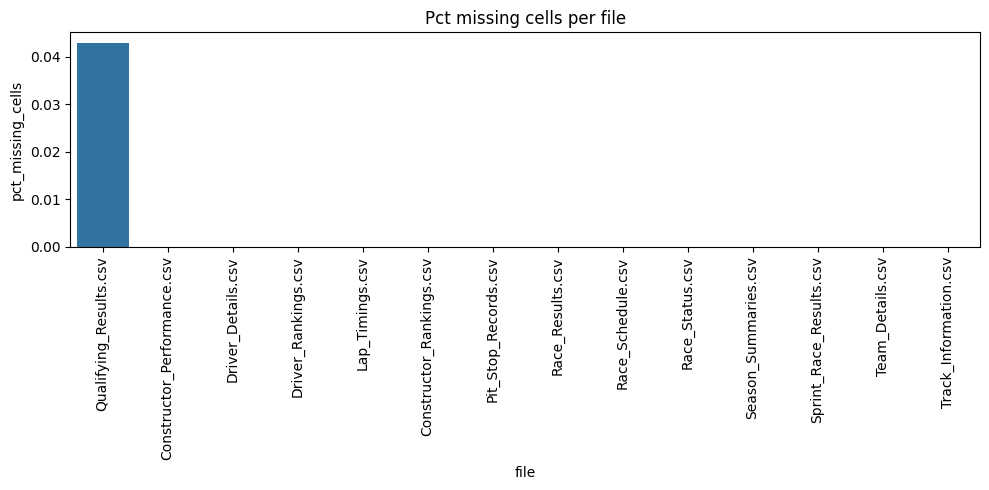

In [9]:
# check visualization
plt.figure(figsize=(10,5))
sns.barplot(data=summary_df, x='file', y='pct_missing_cells')
plt.xticks(rotation=90)
plt.title("Pct missing cells per file")
plt.tight_layout()
plt.show()